# Predicting Space Groups with SchNet

SchNet is a baseline model used across different property predictions of molecules. Atoms in SchNet are represented as xyz coordinates (points) – not as a molecular graph. We convert our xyz coodinates into a graph, so that we can apply a GNN. SchNet was developed for predicting energies and forces from atom configurations without bond information. Thus, we need to first need to convert a set of atoms and their positions into a graph. To get the nodes, we do a similar process as above and the atomic number is passed through an embedding layer, which just means we assign a trainable vector to each atomic number



Features of SchNet:

*   We make the model depend on xyz coordinates by constructing the edge features from the xyz coordinates. The edge (e) between atoms i and j is computed purely from their distance r
*  shifted softplus is used as an activation function. it is smooth with-respect to its input, so it could be used to compute forces in a molecular dynamics simulation which requires taking smooth derivatives with respect to pairwise distances.
*   It uses the Battaglia's GCN Equations for the final node update (involves 3 equations)

*   The GNN updates are applied typically 3-6 times. Although we have an edge update equation, like in GCN we do not actually override the edges and keep them the same at each layer. The original SchNet was for predicting energies and forces, so a readout can be done using sum-pooling or any other strategy described above.
These are sometimes changed, but in the original SchNet paper h1 is one dense layer without activation, h2 is two dense layers with activation, and h3 is 2 dense layers with activation on the first and not the second.


We will use a SchNet model that predict space groups of points. Identifying the space group of atoms is an important part of crystal structure identification, and when doing simulations of crystallization. Our SchNet model will take as input points and output the predicted space group. This is a classification problem; specifically it is multi-class becase a set of points should only be in one space group. To simplify our plots and analysis, we will work in 2D where there are 17 possible space groups.

Our data for this is a set of points from various point groups. The features are xyz coordinates and the label is the space group. We will not have multiple atom types for this problem. we thus loads the data and reshapes it first.

In [2]:
import gzip
import pickle
import urllib
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [3]:
urllib.request.urlretrieve(
    "/data/sym_trajs.pb.gz",
    "sym_trajs.pb.gz",
)
with gzip.open("sym_trajs.pb.gz", "rb") as f:
    trajs = pickle.load(f)

label_str = list(set([k.split("-")[0] for k in trajs]))


# build dataset
def generator():
    for k, v in trajs.items():
        ls = k.split("-")[0]
        label = label_str.index(ls)
        traj = v
        for i in range(traj.shape[0]):
            yield traj[i], label


data = tf.data.Dataset.from_generator(
    generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 2), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32),
    ),
).shuffle(
    1000,
    reshuffle_each_iteration=False,  # we shuffle the data
)

# The shuffling above is really important because this dataset is in order of labels!

val_data = data.take(100)
test_data = data.skip(100).take(100)
train_data = data.skip(200)

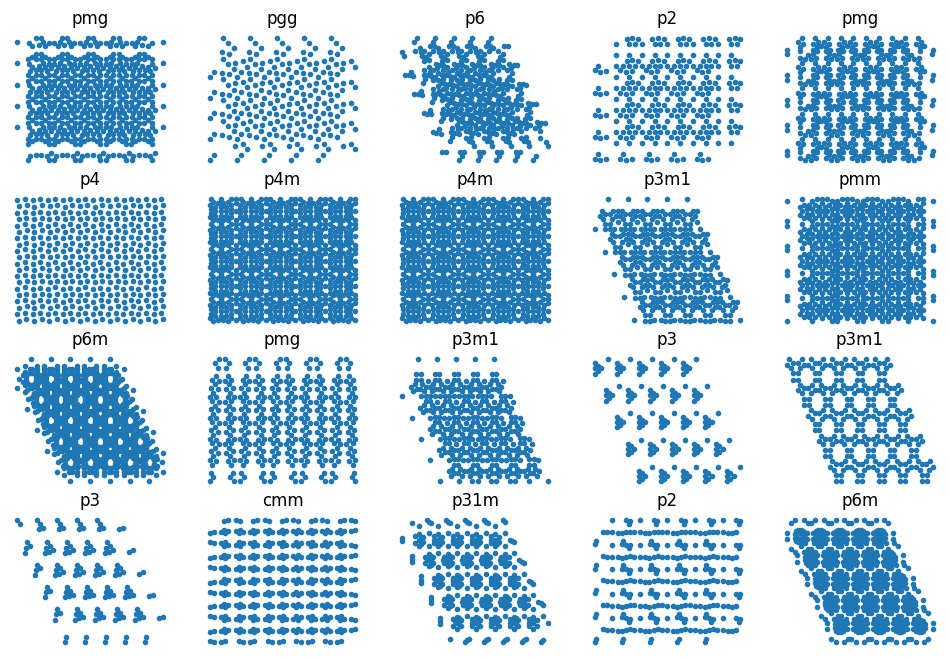

In [4]:
fig, axs = plt.subplots(4, 5, figsize=(12, 8))
axs = axs.flatten()

# we get a few example and plot them
for i, (x, y) in enumerate(data):
    if i == 20:
        break
    axs[i].plot(x[:, 0], x[:, 1], ".")
    axs[i].set_title(label_str[y.numpy()])
    axs[i].axis("off")

We now build the graph for the given data

In [5]:
# we will add a cutoff degree (edges poer node) as 16

# this decorator speeds up the function by "compiling" it (tracing it)
# to run efficienty
@tf.function(
    reduce_retracing=True,
)
def get_edges(positions, NN, sorted=True):
    M = tf.shape(input=positions)[0]
    # adjust NN
    NN = tf.minimum(NN, M)
    qexpand = tf.expand_dims(positions, 1)  # one column
    qTexpand = tf.expand_dims(positions, 0)  # one row
    # repeat it to make matrix of all positions
    qtile = tf.tile(qexpand, [1, M, 1])
    qTtile = tf.tile(qTexpand, [M, 1, 1])
    # subtract them to get distance matrix
    dist_mat = qTtile - qtile
    # mask distance matrix to remove zeros (self-interactions)
    dist = tf.norm(tensor=dist_mat, axis=2)
    mask = dist >= 5e-4
    mask_cast = tf.cast(mask, dtype=dist.dtype)
    # make masked things be really far
    dist_mat_r = dist * mask_cast + (1 - mask_cast) * 1000
    topk = tf.math.top_k(-dist_mat_r, k=NN, sorted=sorted)
    return -topk.values, topk.indices

Just an example of how the graphs will look like:

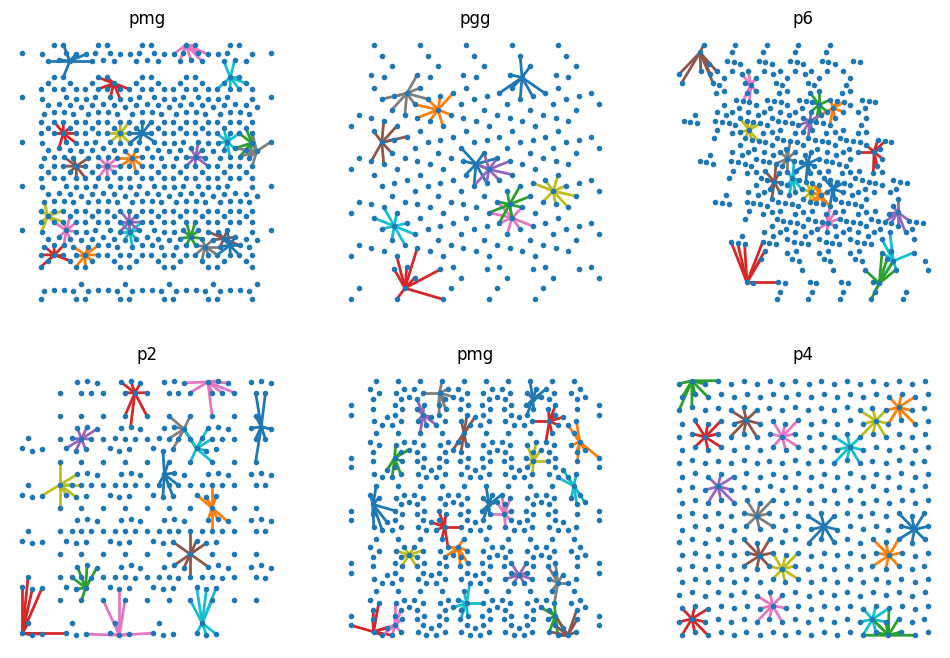

In [6]:
from matplotlib import collections

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.flatten()
for i, (x, y) in enumerate(data):
    if i == 6:
        break
    e_f, e_i = get_edges(x, 8)

    # make things easier for plotting
    e_i = e_i.numpy()
    x = x.numpy()
    y = y.numpy()

    # make lines from origin to its neigbhors
    lines = []
    colors = []
    for j in range(0, x.shape[0], 23):
        # lines are [(xstart, ystart), (xend, yend)]
        lines.extend([[(x[j, 0], x[j, 1]), (x[k, 0], x[k, 1])] for k in e_i[j]])
        colors.extend([f"C{j}"] * len(e_i[j]))
    lc = collections.LineCollection(lines, linewidths=2, colors=colors)
    axs[i].add_collection(lc)
    axs[i].plot(x[:, 0], x[:, 1], ".")
    axs[i].axis("off")
    axs[i].set_title(label_str[y])
plt.show()

Next we create a function for generating graphs

In [7]:
MAX_DEGREE = 16
EDGE_FEATURES = 8
MAX_R = 20

gamma = 1
mu = np.linspace(0, MAX_R, EDGE_FEATURES)


def rbf(r):
    return tf.exp(-gamma * (r[..., tf.newaxis] - mu) ** 2)


def make_graph(x, y):
    edge_r, edge_i = get_edges(x, MAX_DEGREE)
    edge_features = rbf(edge_r)
    return (tf.ones(tf.shape(x)[0], dtype=tf.int32), edge_features, edge_i), y[None]


graph_train_data = train_data.map(make_graph)
graph_val_data = val_data.map(make_graph)
graph_test_data = test_data.map(make_graph)

In [8]:
# Lets check one of the graphs
for (n, e, nn), y in graph_train_data:
    print("first node:", n[1].numpy())
    print("first node, first edge features:", e[1, 1].numpy())
    print("first node, all neighbors", nn[1].numpy())
    print("label", y.numpy())
    break

first node: 1
first node, first edge features: [2.8595981e-01 4.8726115e-02 6.7405581e-10 7.5702485e-25 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00]
first node, all neighbors [  4   0 311  10 312   9 305   7 319 308 309   3   8 320 302  15]
label [7]


Now we can implement the SchNet model! Let’s start with the h1, h2, h3
 MLPs that are used in the GNN update equations. In the SchNet paper these each had different numbers of layers and different decisions about which layers had activation. Let’s create them now.

In [9]:
def ssp(x):
    # shifted softplus activation
    return tf.math.log(0.5 * tf.math.exp(x) + 0.5)


def make_h1(units):
    return tf.keras.Sequential([tf.keras.layers.Dense(units)])


def make_h2(units):
    return tf.keras.Sequential(
        [
            tf.keras.layers.Dense(units, activation=ssp),
            tf.keras.layers.Dense(units, activation=ssp),
        ]
    )


def make_h3(units):
    return tf.keras.Sequential(
        [tf.keras.layers.Dense(units, activation=ssp), tf.keras.layers.Dense(units)]
    )

# we’ve written the functions above to always return a new MLP. This means that a new set of trainable weights
# is generated on each call, meaning there is no way we could erroneously have the same weights in multiple layers.

our readout will be an MLP, following the SchNet paper.We want our output property to be (1) multi-class classification and (2) intensive (independent of number of atoms). So we’ll end with an average (intensive) and end with an output vector of logits the size of our labels.

In [10]:
class SchNetModel(tf.keras.Model):
    """Implementation of SchNet Model"""

    def __init__(self, gnn_blocks, channels, label_dim, **kwargs):
        super(SchNetModel, self).__init__(**kwargs)
        self.gnn_blocks = gnn_blocks

        # build our layers
        self.embedding = tf.keras.layers.Embedding(2, channels)
        self.h1s = [make_h1(channels) for _ in range(self.gnn_blocks)]
        self.h2s = [make_h2(channels) for _ in range(self.gnn_blocks)]
        self.h3s = [make_h3(channels) for _ in range(self.gnn_blocks)]
        self.readout_l1 = tf.keras.layers.Dense(channels // 2, activation=ssp)
        self.readout_l2 = tf.keras.layers.Dense(label_dim)

    def call(self, inputs):
        nodes, edge_features, edge_i = inputs
        # turn node types as index to features
        nodes = self.embedding(nodes)
        for i in range(self.gnn_blocks):
            # get the node features per edge
            v_sk = tf.gather(nodes, edge_i)
            e_k = self.h1s[i](v_sk) * self.h2s[i](edge_features)
            e_i = tf.reduce_sum(e_k, axis=1)
            nodes += self.h3s[i](e_i)
        # readout now
        nodes = self.readout_l1(nodes)
        nodes = self.readout_l2(nodes)
        return tf.reduce_mean(nodes, axis=0)

In [11]:
# Lets test the model on some data
# (Original SchNet Model has more blocks and channels though)
small_schnet = SchNetModel(3, 32, len(label_str))

In [12]:
for x, y in graph_train_data:
    yhat = small_schnet(x)
    break
print(yhat.numpy())

[-0.01093685  0.00771205  0.00476108 -0.02320725  0.01584508  0.00838576
 -0.0144472  -0.00492531  0.0031841  -0.0172138   0.01195906 -0.02478814
  0.02383747  0.00657347 -0.01655336 -0.0076145   0.00883382]


In [13]:
# we use softmax to get proper class prediction
print("predicted class", tf.nn.softmax(yhat).numpy())

predicted class [0.05827593 0.05937291 0.05919796 0.05756523 0.05985776 0.05941292
 0.05807172 0.05862731 0.05910468 0.05791128 0.0596256  0.0574743
 0.06033808 0.05930535 0.05794954 0.05846987 0.05943955]


Now we can set-up training. Our loss will be cross-entropy from logits, but we need to be careful on the form. Our labels are integers - which is called “sparse” labels because they are not full one-hots. Mult-class classification is also known as categorical classification. Thus, the loss we want is sparse categorical cross entropy from logits.

In [14]:
small_schnet.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics="sparse_categorical_accuracy",
)
result = small_schnet.fit(graph_train_data, validation_data=graph_val_data, epochs=25)

Epoch 1/25
1550/1550 [==============================] - 96s 59ms/step - loss: 2.7406 - sparse_categorical_accuracy: 0.0981 - val_loss: 2.7657 - val_sparse_categorical_accuracy: 0.1200
Epoch 2/25
1550/1550 [==============================] - 88s 56ms/step - loss: 2.6894 - sparse_categorical_accuracy: 0.1135 - val_loss: 2.7612 - val_sparse_categorical_accuracy: 0.1200
Epoch 3/25
1550/1550 [==============================] - 86s 56ms/step - loss: 2.6749 - sparse_categorical_accuracy: 0.1097 - val_loss: 2.7405 - val_sparse_categorical_accuracy: 0.1000
Epoch 4/25
1550/1550 [==============================] - 87s 56ms/step - loss: 2.6626 - sparse_categorical_accuracy: 0.1090 - val_loss: 2.7171 - val_sparse_categorical_accuracy: 0.0600
Epoch 5/25
1550/1550 [==============================] - 87s 56ms/step - loss: 2.6555 - sparse_categorical_accuracy: 0.1187 - val_loss: 2.7047 - val_sparse_categorical_accuracy: 0.0600
Epoch 6/25
1550/1550 [==============================] - 93s 60ms/step - loss: 2.

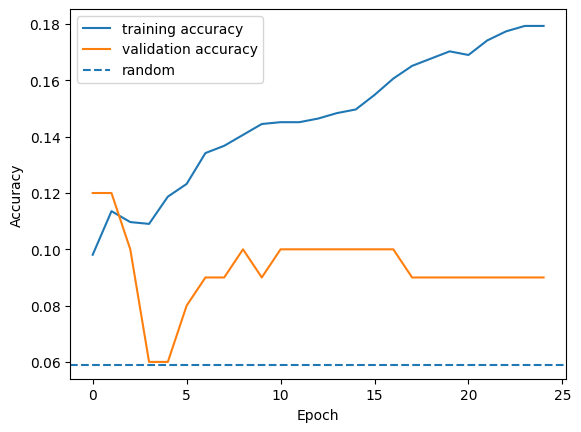

In [15]:
plt.plot(result.history["sparse_categorical_accuracy"], label="training accuracy")
plt.plot(result.history["val_sparse_categorical_accuracy"], label="validation accuracy")
plt.axhline(y=1 / 17, linestyle="--", label="random")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

The accuracy we got is poor bcoz we just trained it on 3 layers, 32 channels and 8 edge features. The original SchNet paper contained 6 layers, 64 channels and 300 edge features. It will require a huge computational power and time to train such a big model. That's why I chose to omit it.

Lets visually see whats going on with the trained model

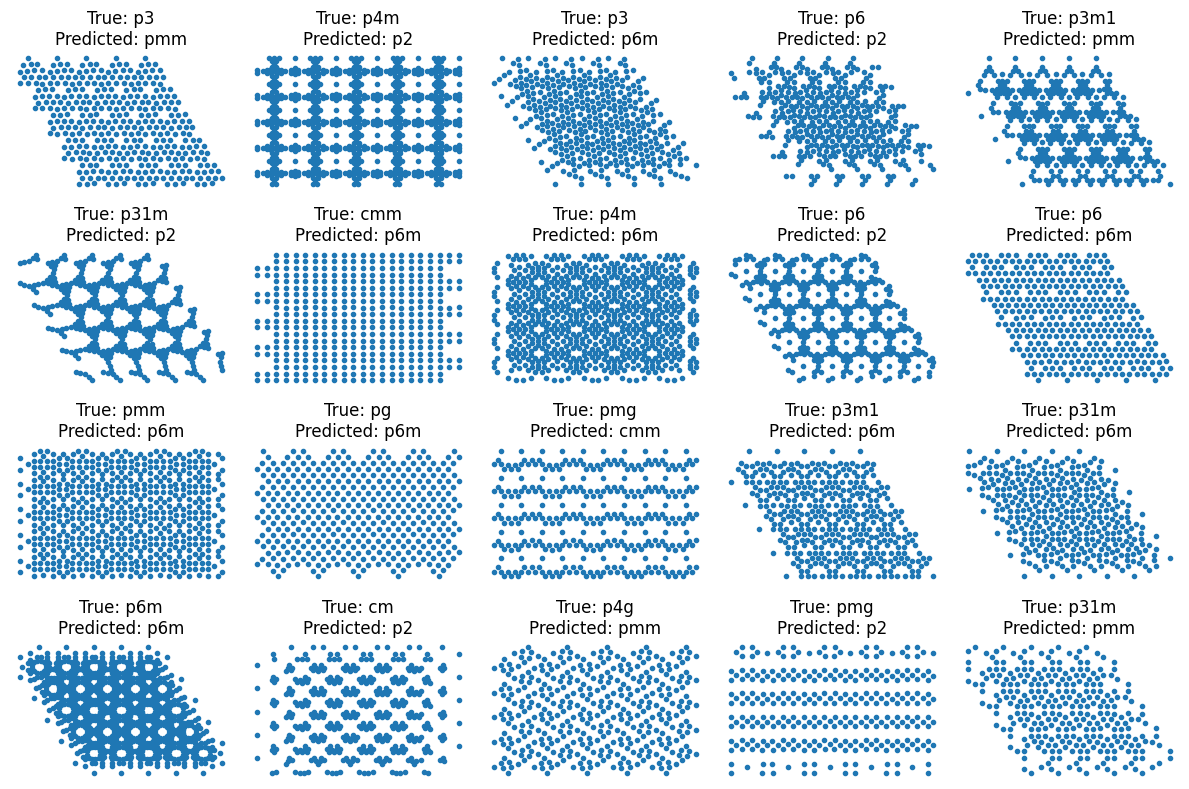

In [16]:
fig, axs = plt.subplots(4, 5, figsize=(12, 8))
axs = axs.flatten()

for i, ((x, y), (gx, _)) in enumerate(zip(test_data, graph_test_data)):
    if i == 20:
        break
    axs[i].plot(x[:, 0], x[:, 1], ".")
    yhat = small_schnet(gx)
    yhat_i = tf.math.argmax(tf.nn.softmax(yhat)).numpy()
    axs[i].set_title(f"True: {label_str[y.numpy()]}\nPredicted: {label_str[yhat_i]}")
    axs[i].axis("off")
plt.tight_layout()
plt.show()